In [1]:
import matplotlib.pyplot as plt
import scipy.integrate
import torch
import sys  
sys.path.insert(0, '..')

from hnn.simulation import get_dataset, get_field, get_trajectory, get_vector_field, integrate_model
from hnn.train import train

In [2]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=200, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--total_steps', default=1000, type=int, help='number of gradient steps')
    parser.add_argument('--name', default='pend', type=str, help='only one option right now')
    parser.add_argument('--field_type', default='solenoidal', type=str, help='type of vector field to learn')
    parser.set_defaults(feature=True)
    return parser.parse_args()

In [3]:
args = get_args()
model, stats = train(args)

/Users/kristinlindquist/development/pinns/src/hnn/../hnn/simulation.py:62: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  dxs.append(torch.stack([dx, dy]).T)


LOSS torch.Size([1050, 2]) torch.Size([1050, 2]) torch.Size([1050, 2]) tensor(6.0872, grad_fn=<MeanBackward0>)
step 0, train_loss 6.0872e+00, test_loss 5.4553e+00
LOSS torch.Size([1050, 2]) torch.Size([1050, 2]) torch.Size([1050, 2]) tensor(5.8264, grad_fn=<MeanBackward0>)
step 1, train_loss 5.8264e+00, test_loss 5.2294e+00
LOSS torch.Size([1050, 2]) torch.Size([1050, 2]) torch.Size([1050, 2]) tensor(5.6009, grad_fn=<MeanBackward0>)
step 2, train_loss 5.6009e+00, test_loss 5.0368e+00
LOSS torch.Size([1050, 2]) torch.Size([1050, 2]) torch.Size([1050, 2]) tensor(5.4063, grad_fn=<MeanBackward0>)
step 3, train_loss 5.4063e+00, test_loss 4.8738e+00
LOSS torch.Size([1050, 2]) torch.Size([1050, 2]) torch.Size([1050, 2]) tensor(5.2389, grad_fn=<MeanBackward0>)
step 4, train_loss 5.2389e+00, test_loss 4.7376e+00
LOSS torch.Size([1050, 2]) torch.Size([1050, 2]) torch.Size([1050, 2]) tensor(5.0966, grad_fn=<MeanBackward0>)
step 5, train_loss 5.0966e+00, test_loss 4.6266e+00
LOSS torch.Size([1050,

In [4]:
GRID_SIZE=10
R = 2.5
t_span=[0, 28]
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

In [5]:

# integrate along those fields starting from point (1,0)
ivp = integrate_model(
        model,
        t_span,
        y0=torch.tensor([2.1, 0.0]),
        rtol=1e-12
)

field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=GRID_SIZE)
vector_field = get_vector_field(model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=GRID_SIZE)


/opt/homebrew/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


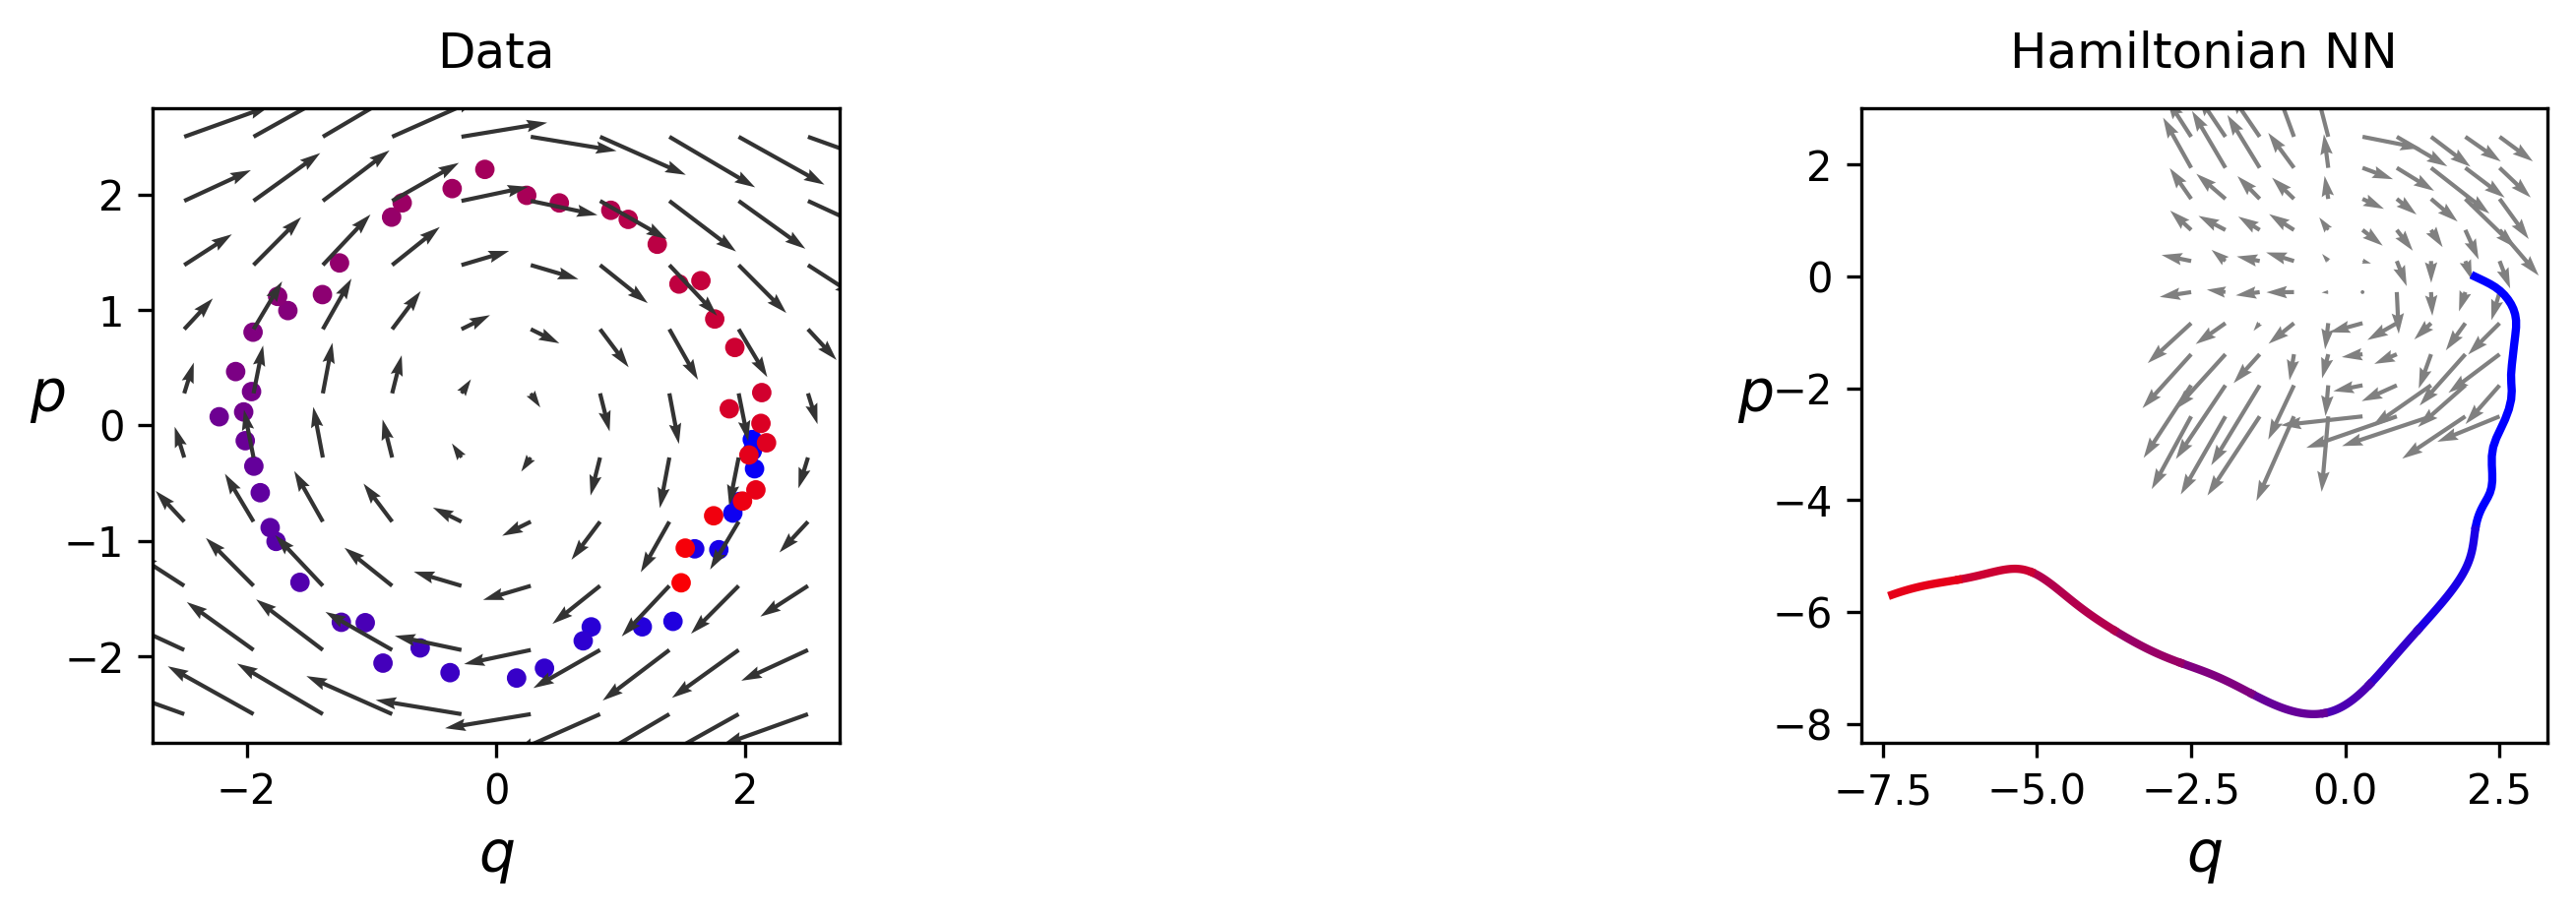

In [6]:
fig = plt.figure(figsize=(11.3, 3.2), facecolor='white', dpi=300)

# plot data
fig.add_subplot(1, 4, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(t_span=[0, 4], radius=2.1, y0=torch.tensor([2.1, 0]))
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x, y, s=14, label='data', c=point_colors)
plt.quiver(
        field['x'][:,0],
        field['x'][:,1],
        field['dx'][:,0],
        field['dx'][:,1],
        cmap='gray_r',
        scale=ARROW_SCALE,
        width=ARROW_WIDTH,
        color=(.2,.2,.2)
)  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot HNN
fig.add_subplot(1, 4, 4, frameon=True)
plt.quiver(
        field['x'][:,0],
        field['x'][:,1],
        vector_field[:,0],
        vector_field[:,1],
        cmap='gray_r',
        scale=ARROW_SCALE,
        width=ARROW_WIDTH,
        color=(.5,.5,.5)
)

for i, l in enumerate(torch.tensor_split(ivp, LINE_SEGMENTS)):
        color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
        plt.plot(l[:, 0], l[:, 1], color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)
plt.tight_layout() ; plt.show()